# Training siamese neural net

## Imports

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import multiprocessing as mp
import itertools
import plotly.express as px
from scipy.stats import entropy
from functools import partial
import re
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset, DataLoader
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Data

In [174]:
# os.chdir("/data/jake/csci_7000-final_project")
os.chdir('/home/jake/ghub/csci-7000-006-neurosymbolic-nlp')

In [175]:
d_tensor_1kg = torch.load("1kg-g2g-tensors.pt")
d_tensor_1kg

{'NA18614': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'HG01918': tensor([1, 1, 1,  ..., 1, 1, 2], dtype=torch.int32),
 'NA18546': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'HG02855': tensor([1, 1, 1,  ..., 1, 2, 1], dtype=torch.int32),
 'HG03565': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'NA19324': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'NA20527': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'NA19107': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'HG01162': tensor([1, 2, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'HG02885': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'NA21126': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'HG00132': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'NA20332': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'NA19087': tensor([1, 1, 1,  ..., 2, 1, 1], dtype=torch.int32),
 'HG02035': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'HG03785': tensor([1, 1,

In [176]:
# scale to pdist range
for k,v in d_tensor_1kg.items():
    s = torch.sum(v)
    d_tensor_1kg[k] = v/s

In [177]:
# set tensor to float 32
for k,v in d_tensor_1kg.items():
    d_tensor_1kg[k] = v.to(torch.float32)

- Note: the l2 distances are already squared for ground truth: $||y||_{2}^{2}$

Remember to sqaure l2 distances in model

In [179]:
df_target = pd.read_csv("1kg-g2g_l2.tsv", sep="\t")
df_target.head()

,l2,s_i,s_j
0,2099.0,NA18614,HG01918
1,2988.0,NA18614,NA18546
2,1381.0,NA18614,HG02855
3,1468.0,NA18614,HG03565
4,1244.0,NA18614,NA19324


- Q: is it better to scale the target vector or leave as is?
- **If scaled**, make sure to transform the embedding distance computed by the model while computing loss (see MSELoss).

<Axes: >

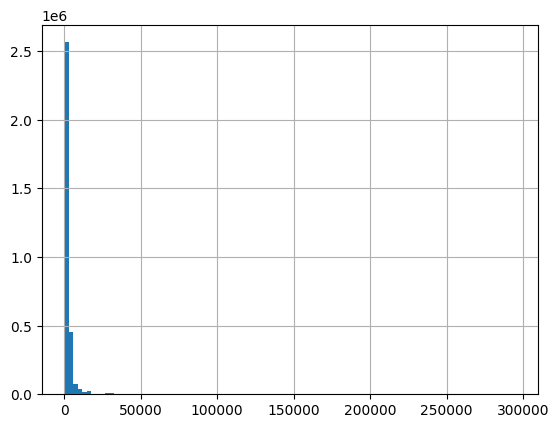

In [180]:
df_target['l2'].hist(bins=100)

- Note: standard scaler would center the targets around 0, however, I don't think it's straghtforward to z-score nomalize each embedding distance computed during training used to compute loss. There's probably a clever or complex way to do this, but it's out of the scope of this project. 

       l2      s_i      s_j    l2_log
0  2099.0  NA18614  HG01918  7.649693
1  2988.0  NA18614  NA18546  8.002694
2  1381.0  NA18614  HG02855  7.231287
3  1468.0  NA18614  HG03565  7.292337
4  1244.0  NA18614  NA19324  7.126891


<Axes: >

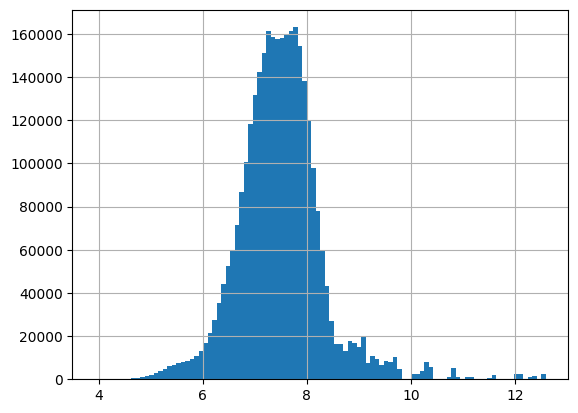

In [181]:
df_target['l2_log'] = df_target['l2'].apply(lambda x: np.log(x+1))
# apply standard scaler
# scaler = StandardScaler()
# df_target['l2_z_log'] = scaler.fit_transform(df_target['l2_z_log'].values.reshape(-1,1))
# df_target['l2_z_log'].hist(bins=100)
print(df_target.head())
df_target['l2_log'].hist(bins=100)

## Model

In [193]:
class SiameseDataset(Dataset):
    def __init__(self, d_tensor, df_target, n_samples=1000, scaled_target=True):
        self.d_tensor = d_tensor
        self.df_target = df_target
        # n samples will define the total length of the dataset
        # we could insted use the length of the dataset (which is the number of samples)
        # len(d_tensor), but this is a lot of data per epoch
        # instead, a sampling pairs approach is used
        self.n_samples = n_samples
        self.scaled_target = scaled_target

    def __len__(self):
        return self.n_samples
        # return len(d_tensor.items())

    def __getitem__(self, idx):
        pair = self.df_target.sample(1)
        s1 = pair["s_i"].values[0]
        t1 = self.d_tensor[s1]
        s2 = pair["s_j"].values[0]
        t2 = self.d_tensor[s2]
        if self.scaled_target:
            target = torch.tensor(pair["l2_log"].values[0], dtype=torch.float32)
        else:
            target = torch.tensor(pair["l2"].values[0], dtype=torch.float32)
        return t1, t2, target

- Quick method for hold out

In [160]:
df_target_test = df_target.sample(1000, random_state=0)
# exclude test from train
# df_target_train = df_target[~df_target.index.isin(df_target_test.index)]
# print(len(df_target_train), len(df_target_test), len(df_target))

- Note: A less stringent approach could be employed

It could be allowed that any sample can be seen during training, yet not allowing for an 
exact pair in the test data set to be seen during training.

- However, I'm using the stringent approach of excluding any sample in the test pairs from the training data

In [183]:
test_samples = pd.concat([df_target_test['s_i'], df_target_test['s_j']]).unique()
test_samples.shape

(1395,)

In [184]:
# filter out test samples
df_target_train = df_target[~df_target['s_i'].isin(test_samples) & ~df_target['s_j'].isin(test_samples)]
print(len(df_target_train), len(df_target_test), len(df_target))
# show that the test samples are not in the train set
print(pd.concat([df_target_train['s_i'], df_target_train['s_j']]).nunique(), len(test_samples))
df_target_train.head()

649230 1000 3211845
1140 1395


,l2,s_i,s_j,l2_log
0,2099.0,NA18614,HG01918,7.649693
1,2988.0,NA18614,NA18546,8.002694
2,1381.0,NA18614,HG02855,7.231287
3,1468.0,NA18614,HG03565,7.292337
5,1670.0,NA18614,NA20527,7.421178


In [188]:
# no need to subset the tensor dictionary since we sample from the target dataframe
# which is paritioned for training samples only
dataset = SiameseDataset(d_tensor_1kg, df_target_train, n_samples=1000,scaled_target=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

It's a bit confusing since the targets are transformed, but here's another reminder:

- Ground truth targets are squared l2 distances, which can optionally be log transformed.
- Therefore, the model l2 embedding distances need to be transformed by the same methods: squared and optional log.

In [189]:
class SiameseNetwork(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(SiameseNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, embedding_dim)
        )
    def forward_one(self, x):
        # compute embedding
        return self.fc(x)

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        return out1, out2
class CustomMSELoss(nn.Module):
    def __init__(self, scaled_target=True):
        super(CustomMSELoss, self).__init__()
        self.scaled_target = scaled_target

    def forward(self, embedding_distance, target_distance):
        # note: the ground truths are *squared* l2 distances
        # this is handled for embedding distance outside of the loss function for now
        
        # if targets are log scaled,
        # also log scaled the embedding distances
        if self.scaled_target:
            embedding_distance = torch.log10(embedding_distance + 1)
            loss = torch.mean((embedding_distance - target_distance) ** 2) # mse
        loss = torch.mean((embedding_distance - target_distance) ** 2)
        return loss

## Train

In [205]:
input_dim = d_tensor_1kg["HG00096"].shape[0]
embedding_dim = 512
print(input_dim,embedding_dim)
model = SiameseNetwork(input_dim, embedding_dim)
model.to(device)
criterion = CustomMSELoss(scaled_target=True) # using log scaled l2
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 20

18721 512


In [206]:
torch.set_num_threads(15) # using gpu, but set this just in case
writer = SummaryWriter(log_dir="logs")
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    l = []
    for i, data in enumerate(dataloader):
        t1, t2, target = data
        t1, t2, target = t1.to(device), t2.to(device), target.to(device)
        # reset grad    
        optimizer.zero_grad()
        output1, output2 = model(t1, t2)
        embedding_distance = torch.sum((output1 - output2) ** 2, dim=1) # squared l2
        loss = criterion(embedding_distance, target)
        loss.backward()
        optimizer.step()
        l.append(loss.item())
        running_loss += loss.item()
        print(f"Epoch {epoch+1}, batch {i+1}, loss: {loss.item()}")
        writer.add_scalar('Loss/train', loss.item(), epoch * len(dataloader) + i)
    print(f"Epoch {epoch+1}, loss: {running_loss}")
writer.close()

Epoch 1, batch 1, loss: 57.111915588378906
Epoch 1, batch 2, loss: 61.00520324707031
Epoch 1, batch 3, loss: 57.372093200683594
Epoch 1, batch 4, loss: 54.97993850708008
Epoch 1, batch 5, loss: 54.21558380126953
Epoch 1, batch 6, loss: 58.90021514892578
Epoch 1, batch 7, loss: 54.97606658935547
Epoch 1, batch 8, loss: 57.40986633300781
Epoch 1, batch 9, loss: 57.511070251464844
Epoch 1, batch 10, loss: 57.78569030761719
Epoch 1, batch 11, loss: 57.799522399902344
Epoch 1, batch 12, loss: 57.142181396484375
Epoch 1, batch 13, loss: 60.017494201660156
Epoch 1, batch 14, loss: 56.27006530761719
Epoch 1, batch 15, loss: 57.81557846069336
Epoch 1, batch 16, loss: 57.027950286865234
Epoch 1, loss: 917.3404350280762
Epoch 2, batch 1, loss: 60.122901916503906
Epoch 2, batch 2, loss: 54.96807861328125
Epoch 2, batch 3, loss: 57.09115219116211
Epoch 2, batch 4, loss: 55.314544677734375
Epoch 2, batch 5, loss: 56.308170318603516
Epoch 2, batch 6, loss: 54.53364181518555
Epoch 2, batch 7, loss: 58

- Since all test samples were excluded, any combination of test samples can be used for evaluation at inference time
- For practical purposes, choose 1000 pairs ground truth versus predicted

In [207]:
df_target_test = df_target[(df_target['s_i'].isin(test_samples)) & (df_target['s_j'].isin(test_samples))]
print(df_target_test.shape)
df_target_test.head()

(972315, 4)


,l2,s_i,s_j,l2_log
12663,739.0,NA19324,HG02885,6.606650
12664,1874.0,NA19324,NA21126,7.536364
12665,1935.0,NA19324,HG00132,7.568379
12668,178.0,NA19324,HG02035,5.187386
12669,211.0,NA19324,HG03785,5.356586


In [208]:
df_target_test_sub = df_target_test.sample(1000, random_state=0)
print(df_target_test_sub.shape)
df_target_test_sub.head()

(1000, 4)


,l2,s_i,s_j,l2_log
539629,4587.0,NA19213,NA19431,8.431199
2023457,1780.0,HG00737,HG01843,7.484930
2276963,2391.0,HG02471,HG03108,7.779885
1279172,2511.0,HG02108,NA19378,7.828835
1403012,815.0,NA20778,HG02819,6.704414


In [213]:
# inference on test pairs
ys = []
y_preds = []
model.eval()
for i, row in df_target_test_sub.iterrows():
    s1 = row['s_i']
    s2 = row['s_j']
    t1 = d_tensor_1kg[s1].to(device)
    t2 = d_tensor_1kg[s2].to(device)
    output1, output2 = model(t1, t2)
    embedding_distance = torch.log10(torch.sum((output1 - output2) ** 2) + 1)
    y = row['l2_log']
    y_pred = embedding_distance.item()
    ys.append(y)
    y_preds.append(y_pred)
    print(f"Pair: {s1}, {s2}, target: {row['l2_log']}, distance: {embedding_distance.item()}")

Pair: NA19213, NA19431, target: 8.431199478249262, distance: 4.855306148529053
Pair: HG00737, HG01843, target: 7.484930283289661, distance: 3.2204277515411377
Pair: HG02471, HG03108, target: 7.779885115070522, distance: 4.8011064529418945
Pair: HG02108, NA19378, target: 7.828834527588089, distance: 3.674321413040161
Pair: NA20778, HG02819, target: 6.704414354964107, distance: 3.6424713134765625
Pair: NA12282, NA19436, target: 7.323830566202317, distance: 4.5352349281311035
Pair: HG02582, NA20898, target: 8.256347772918016, distance: 4.991060733795166
Pair: HG00177, HG03730, target: 7.382124365737512, distance: 4.138256072998047
Pair: HG04035, HG01052, target: 7.502738210754851, distance: 4.428689479827881
Pair: NA20344, HG03867, target: 5.493061443340548, distance: 2.279372215270996
Pair: HG03240, HG02339, target: 7.428927194802272, distance: 3.8827974796295166
Pair: HG01776, HG00332, target: 7.214504414151143, distance: 4.548794746398926
Pair: HG02078, HG03873, target: 7.4133673356952

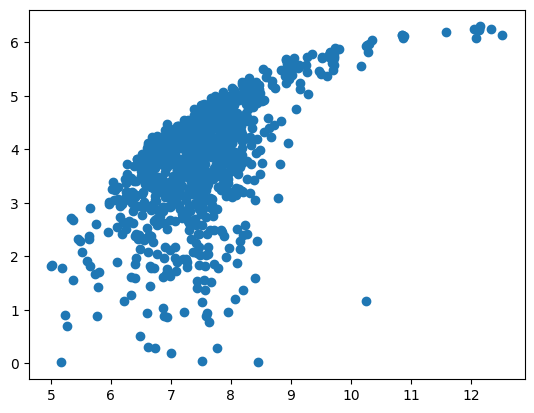

In [214]:
plt.scatter(ys, y_preds)

In [215]:
# inference on train pairs
ys = []
y_preds = []
model.eval()
for i, row in df_target_train.sample(1000).iterrows():
    s1 = row['s_i']
    s2 = row['s_j']
    t1 = d_tensor_1kg[s1].to(device)
    t2 = d_tensor_1kg[s2].to(device)
    output1, output2 = model(t1, t2)
    embedding_distance = torch.log10(torch.sum((output1 - output2) ** 2) + 1)
    y = row['l2_log']
    y_pred = embedding_distance.item()
    ys.append(y)
    y_preds.append(y_pred)
    print(f"Pair: {s1}, {s2}, target: {row['l2_log']}, distance: {embedding_distance.item()}")

Pair: HG03603, NA21124, target: 7.898039690764618, distance: 4.306085109710693
Pair: NA20767, HG00337, target: 8.389814262086407, distance: 2.890347480773926
Pair: HG02496, HG03058, target: 7.913155185928067, distance: 4.671861171722412
Pair: HG03832, NA19247, target: 7.335633981927201, distance: 4.304865837097168
Pair: HG03809, HG02113, target: 6.551080335043404, distance: 3.2678773403167725
Pair: HG02184, NA19058, target: 6.228511003591183, distance: 3.4710607528686523
Pair: HG02131, NA18985, target: 8.40178233990491, distance: 5.062409400939941
Pair: NA19909, HG01863, target: 8.494538500851432, distance: 4.445708751678467
Pair: NA21088, NA19066, target: 10.382512863752321, distance: 5.965264797210693
Pair: HG00736, HG03653, target: 7.058758152518664, distance: 2.7327497005462646
Pair: NA07051, NA19719, target: 9.44375103564617, distance: 4.871711254119873
Pair: HG01354, HG02882, target: 7.67368812926773, distance: 3.5733563899993896
Pair: HG01384, NA20897, target: 7.065613363597717,

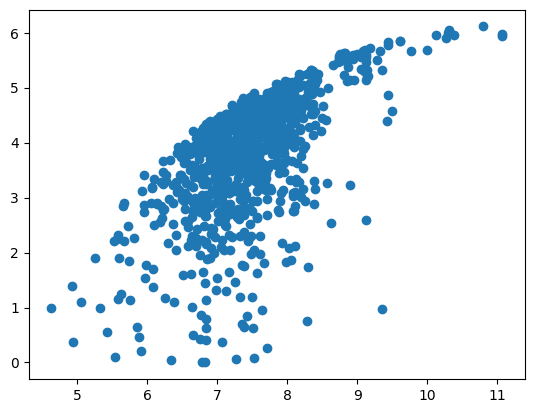

In [216]:

plt.scatter(ys, y_preds)